### Hands-on session #1 

In this lab, we will learn how to use a **supervised** deep learning method to differentiate between two Chinese Neolithic color-painted pottery:
- Banpo (5th to 4th millennium B.C.)
- Banshan(4th to 3rd millennium B.C.) 

<img src="./img/logo.jpeg" width="600" height="300">

**Topics covered include:**
- Image classification with deep learning: Ancient Chinese pottery
- Data preparation (pre-processing, splitting, augmentation)
- Fine-tuning a pre-trained deep learning model with Keras
- Performance evaluation
    - Confusion matrices and performance metrics
    - Receiver operating characteristic curves


The dataset used in this lab is described in the following work. All data credits go to the manuscript authors:

Zhao, Xiaohan, et al. "From classification to matching: A CNN-based approach for retrieving painted pottery images." Digital Applications in Archaeology and Cultural Heritage 29 (2023): e00269.

**To download the dataset you can visit:**
https://data.mendeley.com/datasets/xnk7s6xgxz/1

In [1]:
'''
Splitting your dataset into train/validation/test sets.

This block defines a routine that takes the image directories from Banpo and Banshan images, and splits them into
40/15/45 % (train/validation/test subsets).  ''' 

import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf


# Define directories
banpo_dir = './1-data/Banpo'
banshan_dir = './1-data/Banshan'

# Get list of images in each class directory
banpo_images = os.listdir(banpo_dir)
banshan_images = os.listdir(banshan_dir)

# Shuffle the images
np.random.shuffle(banpo_images)
np.random.shuffle(banshan_images)

# Split the images into train, validation, and test sets
banpo_train_size = int(0.4 * len(banpo_images)) #todo change values
banpo_val_size = int(0.15 * len(banpo_images))

banshan_train_size = int(0.4 * len(banshan_images))
banshan_val_size = int(0.15 * len(banshan_images))

banpo_train_images = banpo_images[:banpo_train_size]
banpo_val_images = banpo_images[banpo_train_size:banpo_train_size + banpo_val_size]
banpo_test_images = banpo_images[banpo_train_size + banpo_val_size:]

banshan_train_images = banshan_images[:banshan_train_size]
banshan_val_images = banshan_images[banshan_train_size:banshan_train_size + banshan_val_size]
banshan_test_images = banshan_images[banshan_train_size + banshan_val_size:]

# Create train, validation, and test directories
train_dir = './1-data/train'
val_dir = './1-data/val'
test_dir = './1-data/test'

# Create subdirectories for each class within train, validation, and test directories
train_banpo_dir = os.path.join(train_dir, 'Banpo')
train_banshan_dir = os.path.join(train_dir, 'Banshan')
val_banpo_dir = os.path.join(val_dir, 'Banpo')
val_banshan_dir = os.path.join(val_dir, 'Banshan')
test_banpo_dir = os.path.join(test_dir, 'Banpo')
test_banshan_dir = os.path.join(test_dir, 'Banshan')

os.makedirs(train_banpo_dir, exist_ok=True)
os.makedirs(train_banshan_dir, exist_ok=True)
os.makedirs(val_banpo_dir, exist_ok=True)
os.makedirs(val_banshan_dir, exist_ok=True)
os.makedirs(test_banpo_dir, exist_ok=True)
os.makedirs(test_banshan_dir, exist_ok=True)

# Function to copy images to destination directory
def copy_images(src_dir, dest_dir, images):
    for img in images:
        src_path = os.path.join(src_dir, img)
        dest_path = os.path.join(dest_dir, img)
        shutil.copyfile(src_path, dest_path)

# Copy images to train directory
copy_images(banpo_dir, train_banpo_dir, banpo_train_images)
copy_images(banshan_dir, train_banshan_dir, banshan_train_images)

# Copy images to validation directory
copy_images(banpo_dir, val_banpo_dir, banpo_val_images)
copy_images(banshan_dir, val_banshan_dir, banshan_val_images)

# Copy remaining images to test directory
copy_images(banpo_dir, test_banpo_dir, banpo_test_images)
copy_images(banshan_dir, test_banshan_dir, banshan_test_images)

2024-02-25 17:50:39.420777: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
''' Data generators:
    Take a look at the ImageDataGenerator function from tensorflow in order to:
    
    1) Define a train-set image generator named 'train_datagen'
    2) Rescale your images to the interval [1,255]
    2) Augment your images in real-time by performing random rotations, shifts, zooming, shearing, and horizontal flips.
    You can get help from ChatGPT.

''' 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator( #fill me in #)

In [2]:
''' Data generators:
    Lets define similar data generators for the validation and test sets.
    
    Question: 
    Why the validation and test data generators are not augmented? 

''' 

# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 207 images belonging to 2 classes.
Found 89 images belonging to 2 classes.
Found 175 images belonging to 2 classes.


**Let's use a pre-trained neural network to classify our images.** 

The network we'll use is VGG16 (Simonyan, Karen, and Andrew Zisserman. "Very deep convolutional networks for large-scale image recognition." arXiv preprint arXiv:1409.1556 (2014))

The technique to be used is called **fine-tuning**: most CNN layer weights are gonna be preserved; the last fully connected layers of the network, instead, are gonna be re-trained for the task at hand typically by using a small learning rate.

VGG16 has been trainned in a large visual dataset called **ImageNet**. The current version of the dataset includes over 10 million images (!) with over 15 thousand image classes (!).

**VGG16**
<img src="./img/vgg16.png" width="600" height="300">

Image source: Researchgate.net

Epoch 1/10
6/6 [==============================] - ETA: 0s - loss: 0.7239 - accuracy: 0.5543 
Epoch 1: val_accuracy improved from -inf to 0.84375, saving model to best_model.h5


/Users/edelarosa/miniconda3/envs/tifa/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 120s 20s/step - loss: 0.7239 - accuracy: 0.5543 - val_loss: 0.5177 - val_accuracy: 0.8438
Epoch 2/10
6/6 [==============================] - ETA: 0s - loss: 0.5068 - accuracy: 0.7657 
Epoch 2: val_accuracy improved from 0.84375 to 0.92188, saving model to best_model.h5
6/6 [==============================] - 104s 17s/step - loss: 0.5068 - accuracy: 0.7657 - val_loss: 0.3731 - val_accuracy: 0.9219
Epoch 3/10
6/6 [==============================] - ETA: 0s - loss: 0.4050 - accuracy: 0.8743 
Epoch 3: val_accuracy did not improve from 0.92188
6/6 [==============================] - 95s 16s/step - loss: 0.4050 - accuracy: 0.8743 - val_loss: 0.3265 - val_accuracy: 0.8906
Epoch 4/10
6/6 [==============================] - ETA: 0s - loss: 0.3151 - accuracy: 0.8914 
Epoch 4: val_accuracy improved from 0.92188 to 0.93750, saving model to best_model.h5
6/6 [==============================] - 106s 20s/step - loss: 0.3151 - accuracy: 0.8914 - val_loss: 0.2375 - val_

<module 'matplotlib.pyplot' from '/Users/edelarosa/miniconda3/envs/tifa/lib/python3.9/site-packages/matplotlib/pyplot.py'>

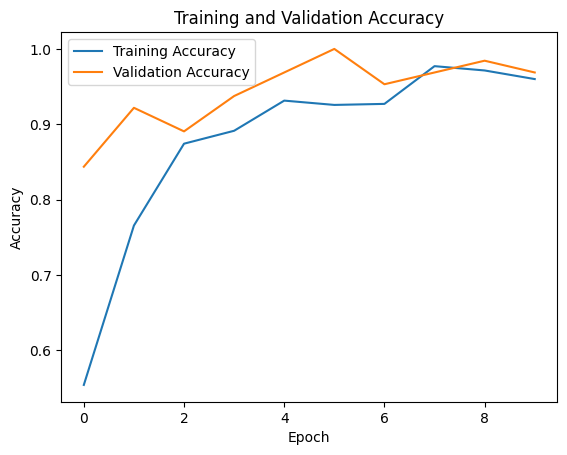

In [3]:
''' Here we define VGG16 as the CNN backbone to use in our experiments. We are gonna used the weights pretrainned in ImageNet.
    Note that, unlike the original version of VGG16 we are gonna classify betweeen two image classes. This is obtained through a
    Sigmoid activation function.
    Lets re-train our model for a few epochs (note: this might take a few mins, specially if your don't have a GPU!).
''' 

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model


# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define checkpoint callback
checkpoint_path = "best_model.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint]
)

# Evaluate the model on test data
# _, test_acc = model.evaluate(test_generator) #todo change
# print('Accuracy on test: ', test_acc)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt

/var/folders/9j/9nd6ksj93_3bp16hqxz7gsb80000gp/T/ipykernel_25955/2555394857.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_preds = model.predict_generator(test_generator)


6/6 [==============================] - 67s 11s/step - loss: 0.1161 - accuracy: 0.9714
Accuracy on test:  0.9714285731315613


## How well our model performs?

Using Chat-GPT fill in the next code block in order to:
1) Get a confusion matrix from your real and predicted image labels and plot it.
2) Answer: What is the accuracy, sensitivity and specificity of the model?

In [ ]:
''' Fill in this script to answer points 1) and 2).
    Having issues? The next block provides a possible answer.'''
# first predict the test images
test_preds = model.predict_generator(test_generator)
y_pred = tf.where(test_preds<=0.5,0,1)
y_true = test_generator.labels

# calculate the CM and find accuracy, sensitivity and specificity

Accuracy:  0.9714285714285714
Sensitivity:  0.9659090909090909
Sensitivity:  0.9770114942528736


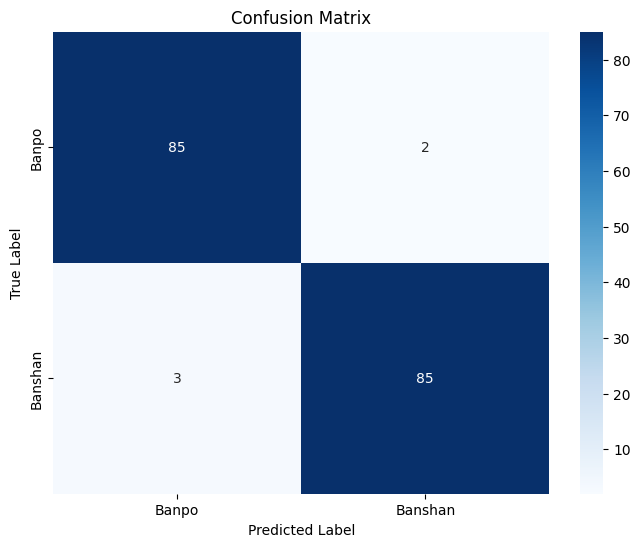

In [5]:
''' Confusion matrices and performance metrics- Cheat code.'''

# from sklearn.metrics import confusion_matrix, accuracy_score
# import seaborn as sns

# # predict the test images
# test_preds = model.predict_generator(test_generator)
# y_pred = tf.where(test_preds<=0.5,0,1)
# y_true = test_generator.labels

# cm = confusion_matrix(y_true, y_pred)

# true_positives = cm[1, 1]
# true_negatives = cm[0, 0]
# false_positives = cm[0, 1]
# false_negatives = cm[1, 0]

# accuracy = (true_positives + true_negatives) / np.sum(cm)
# sensitivity = true_positives / (true_positives + false_negatives)
# specificity = true_negatives / (true_negatives + false_positives)

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Banpo', 'Banshan'], yticklabels=['Banpo', 'Banshan'])
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# print('Accuracy: ', accuracy)
# print('Sensitivity: ', sensitivity)
# print('Sensitivity: ', specificity)
# plt.show()

# metrics = ['Accuracy', 'Sensitivity', 'Specificity']
# values = [accuracy, sensitivity, specificity]

# plt.bar(metrics, values, color=['blue', 'green', 'red'])
# plt.title('Model Evaluation Metrics')
# plt.ylabel('Value')
# plt.ylim(0, 1)  # Setting y-axis limit to range [0, 1]
# plt.show()

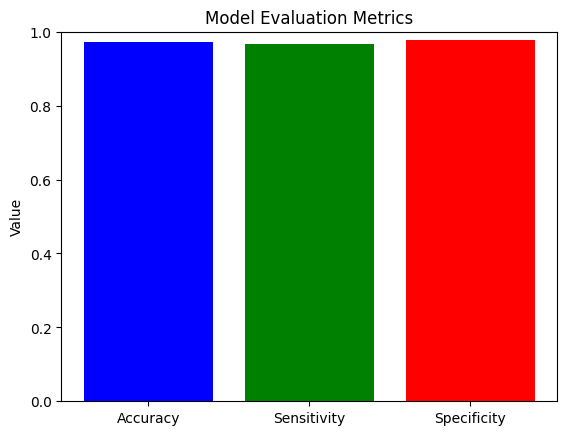

## Receiver-operating characteristic (ROC) analysis ##


<img src="./img/roc.jpeg" width="400" height="200">



**ROC analysis is a powerful tool o evaluate the performance of classification models.
Using chat-GPT, answer:**

1) What is a ROC curve and what is the meaning of the area under it?
2) What is an 'operating point' and how it can be derived from the curve?
3) ROC curves vs precision-recall curves: What are their differences? When to choose using one over the other?
4) Hands-on: plot a ROC curve for the model fine-tuned in the previous blocks.    

**Answers:**

1)
2)
3)

In [ ]:
''' Answer #4: Code your ROC curve
(if you encounter any issue, you can get inspiration from the code below)

''' 

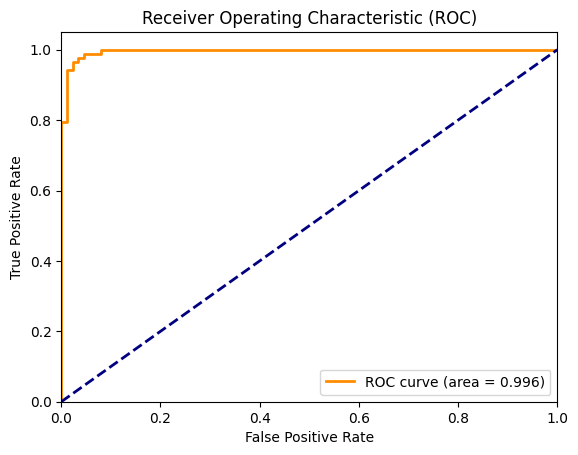

In [13]:


''' Performance evaluation: Receiver Operating Charateristic Curves
    Back-up: script '''

# from sklearn.metrics import roc_curve, auc

# # Compute ROC curve
# fpr, tpr, thresholds = roc_curve(y_true, test_preds)

# # Compute AUC
# roc_auc = auc(fpr, tpr)

# # Plot ROC curve
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC)')
# plt.legend(loc="lower right")
# plt.show()

/var/folders/9j/9nd6ksj93_3bp16hqxz7gsb80000gp/T/ipykernel_25955/2973795940.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_preds = model.predict_generator(test_generator)


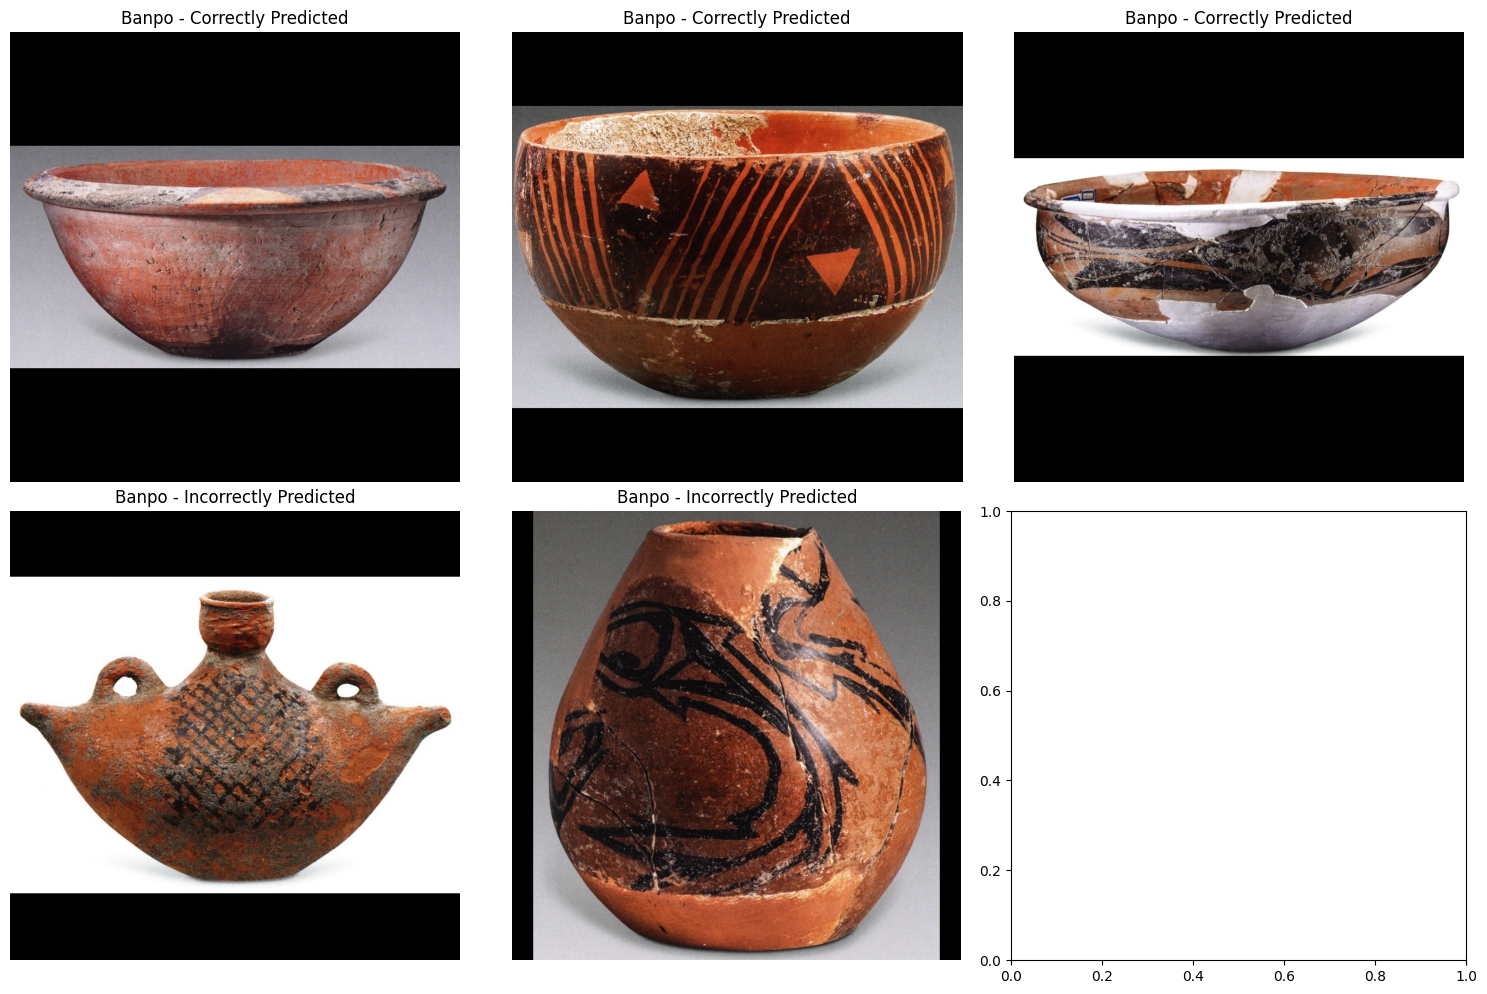

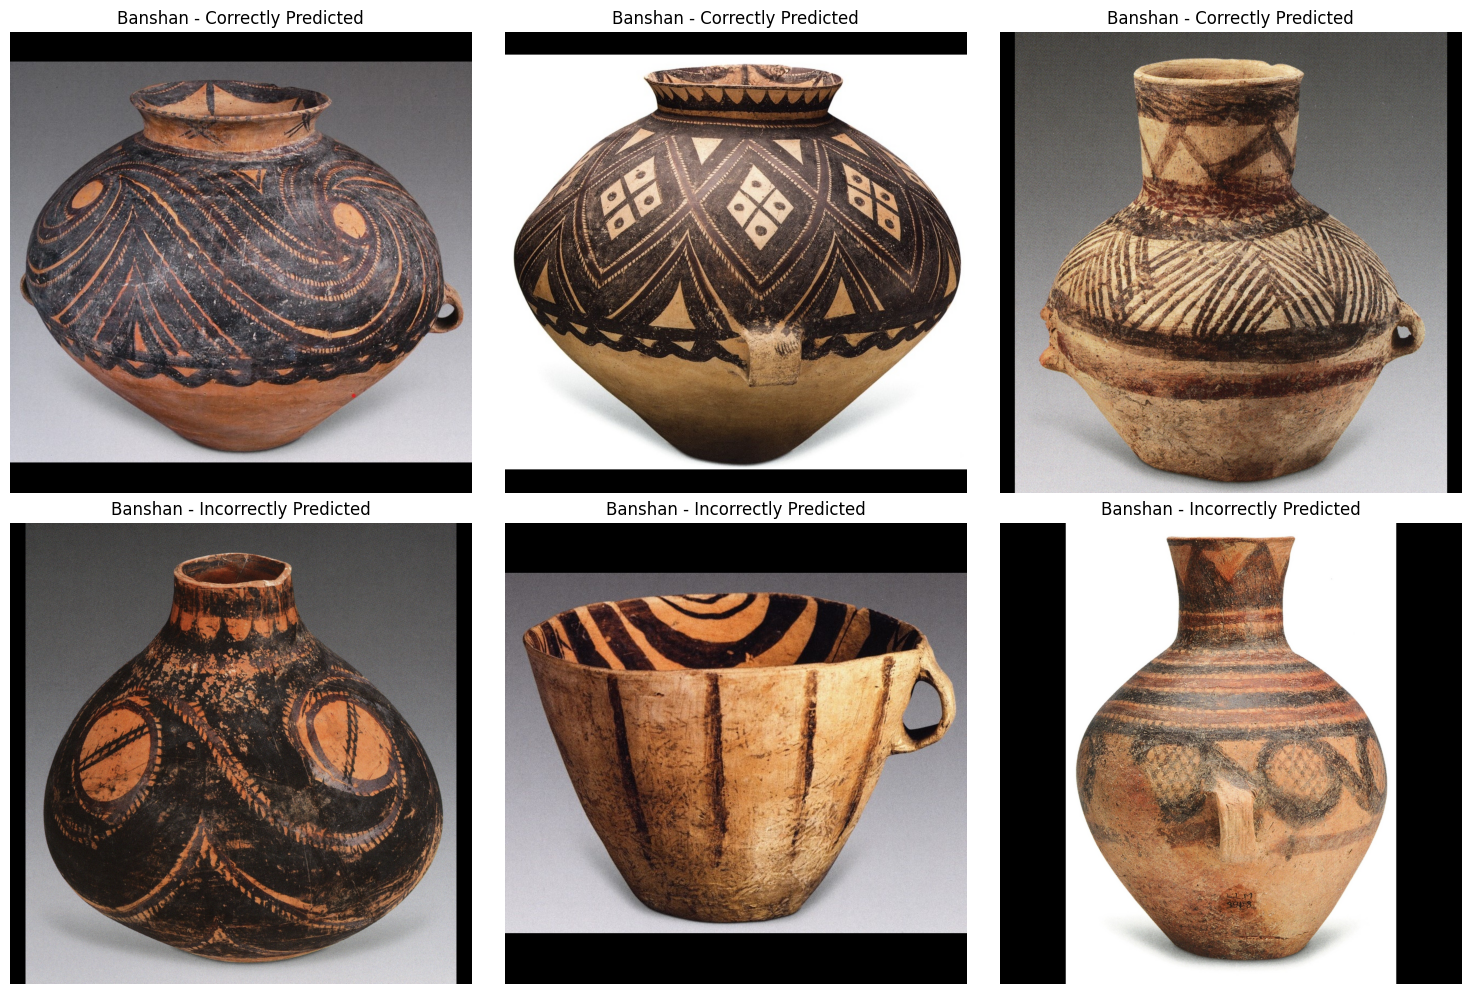

In [24]:
''' 
ALWAYS VISUALIZE YOUR IMAGES: 
Understanding the weakness of a machine-learning model is crucial to identify bugs, model failures, and to lead improvements on it. 
Visualizing (plotting) which images are correctly predicted and which ones not sheds light on the model limitations.

Let's visualize a couple of images correctly/incorrectly predicted for each of the image classes.''' 

import random
def plot_random_images(model, test_generator):
    # Get predictions
    test_preds = model.predict_generator(test_generator)
    y_pred = tf.where(test_preds <= 0.5, 0, 1)
    y_true = test_generator.classes
    
    # Get indices of correctly and incorrectly predicted images for each class
    correct_banpo_indices = [idx for idx, (pred, true) in enumerate(zip(y_pred, y_true)) if pred == true == 0]
    incorrect_banpo_indices = [idx for idx, (pred, true) in enumerate(zip(y_pred, y_true)) if pred != true == 0]
    
    correct_banshan_indices = [idx for idx, (pred, true) in enumerate(zip(y_pred, y_true)) if pred == true == 1]
    incorrect_banshan_indices = [idx for idx, (pred, true) in enumerate(zip(y_pred, y_true)) if pred != true == 1]
    
    # Randomly select 3 indices for each class
    selected_correct_banpo_indices = random.sample(correct_banpo_indices, min(3, len(correct_banpo_indices)))
    selected_incorrect_banpo_indices = random.sample(incorrect_banpo_indices, min(3, len(incorrect_banpo_indices)))
    
    selected_correct_banshan_indices = random.sample(correct_banshan_indices, min(3, len(correct_banshan_indices)))
    selected_incorrect_banshan_indices = random.sample(incorrect_banshan_indices, min(3, len(incorrect_banshan_indices)))
    
    # Plot selected images for Banpo class
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    for i, idx in enumerate(selected_correct_banpo_indices):
        img_path = os.path.join(test_generator.directory, 'Banpo', test_generator.filenames[idx].split('/')[-1])
        img = plt.imread(img_path)
        axes[0, i].imshow(img)
        axes[0, i].set_title('Banpo - Correctly Predicted')
        axes[0, i].axis('off')
        
    for i, idx in enumerate(selected_incorrect_banpo_indices):
        img_path = os.path.join(test_generator.directory, 'Banpo', test_generator.filenames[idx].split('/')[-1])
        img = plt.imread(img_path)
        axes[1, i].imshow(img)
        axes[1, i].set_title('Banpo - Incorrectly Predicted')
        axes[1, i].axis('off')
    
    fig.tight_layout()
    plt.show()

    # Plot selected images for Banshan class
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    for i, idx in enumerate(selected_correct_banshan_indices):
        img_path = os.path.join(test_generator.directory, 'Banshan', test_generator.filenames[idx].split('/')[-1])
        img = plt.imread(img_path)
        axes[0, i].imshow(img)
        axes[0, i].set_title('Banshan - Correctly Predicted')
        axes[0, i].axis('off')
        
    for i, idx in enumerate(selected_incorrect_banshan_indices):
        img_path = os.path.join(test_generator.directory, 'Banshan', test_generator.filenames[idx].split('/')[-1])
        img = plt.imread(img_path)
        axes[1, i].imshow(img)
        axes[1, i].set_title('Banshan - Incorrectly Predicted')
        axes[1, i].axis('off')
    
    fig.tight_layout()
    plt.show()

plot_random_images(model, test_generator)
